# Equations of Motion for a Rigid Body


In [281]:
:dep ndarray = { version = "0.16.1" }
:dep plotly = { version = "0.10.0" }
:dep nalgebra = { version = "0.33.1" }
extern crate ndarray;
extern crate plotly;
extern crate nalgebra;

use ndarray::{Array, Array2};
use nalgebra::{SMatrix, SVector};
use plotly::common::Mode;
use plotly::layout::{Layout};
use plotly::{Plot, Scatter};

In [397]:
// Quaternion rotation.manmanman
use std::f64::consts::PI;
let (mut q0, mut q1, q2, q3): (f64, f64, f64, f64) = (1.0, 0.0, 0.0, 0.0);

// 45 degrees roll:
q0 = (PI / 8.0).cos();
q1 = (PI / 8.0).sin();

// Construct the rotation matrix from quaternion
let R11 = q0.powi(2) + q1.powi(2) - q2.powi(2) - q3.powi(2);
let R22 = q0.powi(2) - q1.powi(2) + q2.powi(2) - q3.powi(2);
let R33 = q0.powi(2) - q1.powi(2) - q2.powi(2) + q3.powi(2);
let R12 = 2.0 * (q1 * q2 - q0 * q3);
let R21 = 2.0 * (q1 * q2 + q0 * q3);
let R13 = 2.0 * (q1 * q3 + q0 * q2);
let R31 = 2.0 * (q1 * q3 - q0 * q2);
let R23 = 2.0 * (q2 * q3 - q0 * q1);
let R32 = 2.0 * (q2 * q3 + q0 * q1);
let R = SMatrix::<f64, 3, 3>::new(
    R11, R12, R13,
    R21, R22, R23,
    R31, R32, R33
);
let RT = R.transpose();

println!("{}", RT * SVector::<f64, 3>::new(0.0, 0.0, 1.0));


  ┌                    ┐
  │                  0 │
  │ 0.7071067811865476 │
  │ 0.7071067811865475 │
  └                    ┘




In [481]:
#[derive(Debug)]
struct RigidBody {
    mass: f64,
    I: SMatrix::<f64, 3, 3>,
    I_inv: SMatrix::<f64, 3, 3>,
    
    // Define the state vector
    // 0 u
    // 1 v
    // 2 w
    // 3 p
    // 4 q
    // 5 r
    // 6 q0
    // 7 q1
    // 8 q2
    // 9 q3
    // 10 pn
    // 11 pe
    // 12 pd
    // 13 phi
    // 14 theta
    // 15 psi
    x: SVector::<f64, 16>,
}

impl RigidBody {
    fn new(I: SMatrix::<f64, 3, 3>, mass: f64, initial_state: SVector::<f64, 16>) -> Self {

        let I_inv = I.try_inverse().unwrap();
        
        Self {
            mass,
            I,
            I_inv,
            x: initial_state,
        }
    }

    fn normalize_quaternion(&mut self) {
        let mut q = SVector::<f64, 4>::new(self.x[6], self.x[7], self.x[8], self.x[9]);
        q.normalize();

        self.x[6] = q[0];
        self.x[7] = q[1];
        self.x[8] = q[2];
        self.x[9] = q[3];
    }

    fn quaternion_to_euler(&mut self) {
        let angles = SVector::<f64, 3>::zeros();
        let (q0, q1, q2, q3) = (self.x[6], self.x[7], self.x[8], self.x[9]);

        // Roll (phi)
        self.x[13] = (2.0 * (q0 * q1 + q2 * q3)).atan2(1.0 - 2.0 * (q1.powi(2) + q2.powi(2)));
    
        // Pitch (theta)
        self.x[14] = 2.0 * ((1.0 + 2.0 * (q0 * q2 - q1 * q3)).sqrt()).atan2((1.0 - 2.0 * (q0 * q2 - q1 * q3)).sqrt()) - std::f64::consts::PI * 0.5;
    
        // Yaw (psi)
        self.x[15] = (2.0 * (q0 * q3 + q1 * q2)).atan2(1.0 - 2.0 * (q2.powi(2) + q3.powi(2)));

    }

    fn calculate_state_derivative(&self, x: &SVector::<f64, 16>) -> (SVector::<f64, 16>, SMatrix::<f64, 3, 3>) {
        //   0  1  2  3  4  5   6   7   8   9  10  11  12
        let (u, v, w, p, q, r, q0, q1, q2, q3, pn, pe, pd) = (x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12]);
        
        let mut M = SVector::<f64, 3>::zeros();
        

        // Construct the rotation matrix from quaternion
        let R11 = q0.powi(2) + q1.powi(2) - q2.powi(2) - q3.powi(2);
        let R22 = q0.powi(2) - q1.powi(2) + q2.powi(2) - q3.powi(2);
        let R33 = q0.powi(2) - q1.powi(2) - q2.powi(2) + q3.powi(2);
        let R12 = 2.0 * (q1 * q2 - q0 * q3);
        let R21 = 2.0 * (q1 * q2 + q0 * q3);
        let R13 = 2.0 * (q1 * q3 + q0 * q2);
        let R31 = 2.0 * (q1 * q3 - q0 * q2);
        let R23 = 2.0 * (q2 * q3 - q0 * q1);
        let R32 = 2.0 * (q2 * q3 + q0 * q1);
        let R = SMatrix::<f64, 3, 3>::new(
            R11, R12, R13,
            R21, R22, R23,
            R31, R32, R33
        );
        let RT = R.transpose();

        // Calculate the attachment point of the spring
        // Block with dimensions 10x40x5 cm (x,y,z)
        let r_body = SVector::<f64, 3>::new(0.05, 0.1, 0.025);
        // let r_body = SVector::<f64, 3>::new(0.05, 0.2, 0.025);
        let r_ned = R * r_body;
        
        // Velocity in body frame
        let Vb = SVector::<f64, 3>::new(u, v, w);
        let Vned = R * Vb;

        let mut Fned = SVector::<f64, 3>::zeros();

        let Vmagnitude = Vned.norm();
        let mut Fdrag = SVector::<f64, 3>::zeros();
        if Vmagnitude > 0.0 {
            let Vdirection = Vned.normalize();
            Fdrag += Vmagnitude.powi(2) * -0.0245 * Vdirection;
        }
        Fned += Fdrag;
        
        // Create a spring, which only acts when length is > min_length. origin of spring at 0,0,0
        let min_length = 2.0;
        let r_spring = SVector::<f64, 3>::new(pn, pe, pd) + r_ned;
        let r_spring_norm = r_spring.normalize();
        let mut Kspring = 50.0;
        if r_spring.norm() <= min_length {
            Kspring = 0.0;
        }
        let Fspring = -Kspring * (r_spring - min_length * r_spring_norm);
        Fned += Fspring;
        let Fspring_body = RT * Fspring;
        let Mspring = r_body.cross(&Fspring_body);
        M += Mspring;

        let Fgravity_ned = SVector::<f64, 3>::new(0.0, 0.0, 9.80665 * self.mass);
        Fned += Fgravity_ned;
        
        // // Pull opposite to gravity at r
        // let Fup = -Fgravity_ned;
        // Fned += Fup;
        // let Fup_body = RT * Fup;
        // let Mup_body = r_body.cross(&Fup_body);
        // M += Mup_body;

        let Fgravity_body = RT * Fgravity_ned;
        // let Fgravity_body = 2.0 * 9.80665 * SVector::<f64, 3>::new(
        //     2.0 * (q1 * q3 + q0 * q2),
        //     2.0 * (q2 * q3 - q0 * q1),
        //     1.0 - 2.0 * (q1 * q1 + q2 * q2)
        // );
        
        let F = RT * Fned;
        // let F = SVector::<f64, 3>::zeros();

        let omega = SVector::<f64, 3>::new(p, q, r);
        // let Mdamp = -10.0 * omega;
        // M += Mdamp;
        M += -0.01 * omega;
        
        // I'll try to do the coriolis stuff here
        let part1 = self.I * omega;
        let coriolis = omega.cross(&part1);
        
        let omega_dot = self.I_inv * (M - coriolis);

        let mut x_dot = SVector::<f64, 16>::zeros();
        x_dot[0] = (F[0] / self.mass) - w * q + v * r;
        x_dot[1] = (F[1] / self.mass) - u * r + w * p;
        x_dot[2] = (F[2] / self.mass) - v * p + u * q;
        x_dot[3] = omega_dot[0];
        x_dot[4] = omega_dot[1];
        x_dot[5] = omega_dot[2];
        x_dot[6] = - 0.5 * (q1 * p + q2 * q + q3 * r); // q0
        x_dot[7] = 0.5 * (q0 * p + q2 * r - q3 * q);   // q1
        x_dot[8] = 0.5 * (q0 * q + q3 * p - q1 * r);   // q2
        x_dot[9] = 0.5 * (q0 * r + q1 * q - q2 * p);   // q3

        x_dot[10] = Vned[0];
        x_dot[11] = Vned[1];
        x_dot[12] = Vned[2];

        let test = SVector::<f64, 3>::new(x_dot[0], x_dot[1], x_dot[2]);
        
        (x_dot, nalgebra::SMatrix::from_rows(&[Fgravity_ned.transpose(), Fspring.transpose(), Fdrag.transpose()]))
    }

    fn propagate_state(&self, dt: f64) -> (SVector::<f64, 16>, SVector::<f64, 16>, SMatrix::<f64, 3, 3>) {
        // Runge Kutta

        let x = self.x.clone();
        let (k1, f1) = self.calculate_state_derivative(&x);
        
        let x1 = x + (0.5 * dt) * k1;
        let (k2, f2) = self.calculate_state_derivative(&x1);
        
        let x2 = x + (0.5 * dt) * k2;
        let (k3, f3) = self.calculate_state_derivative(&x2);
        
        let x3 = x + dt * k3;
        let (k4, f4) = self.calculate_state_derivative(&x3);
        
        let x4 = x + (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4);
        let x4_dot = (k1 + 2.0 * k2 + 2.0 * k3 + k4) / 6.0;

        let f = (f1 + 2.0 * f2 + 2.0 * f3 + f4) / 6.0;

        (x4, x4_dot, f)
        
    }

    fn run(&mut self, steps: usize, dt: f64) -> (ndarray::Array1<f64>, Array2<f64>, Array2<f64>) {
        let mut time_series: ndarray::Array1<f64> = ndarray::Array1::<f64>::zeros(steps);
        let mut output_series: Array2<f64> = Array2::<f64>::zeros((steps, 16));
        let mut output_forces: Array2<f64> = Array2::<f64>::zeros((steps, 9));

        let mut xdot = SVector::<f64, 16>::zeros();
        let mut f = SMatrix::<f64, 3, 3>::zeros();
        
        let mut t = 0.0;
        for i in 0..steps {
            time_series[i] = t;
            let x_slice = self.x.as_slice();
            let x_view = ndarray::Array1::from(x_slice.to_vec());
            output_series.slice_mut(ndarray::s![i, 0..]).assign(&x_view);

            for j in 0..3 {
                let fj_owned = f.row(j).clone_owned();
                let f_slice = fj_owned.as_slice();
                let f_view = ndarray::Array1::from(f_slice.to_vec());
                output_forces.slice_mut(ndarray::s![i, (j*3)..(j*3+3)]).assign(&f_view);
            }

            let (new_x, new_xdot, new_f) = self.propagate_state(dt);
            self.x = new_x;
            xdot = new_xdot;
            f = new_f;
            self.normalize_quaternion();
            self.quaternion_to_euler();
            t += dt;

        }

        (time_series, output_series, output_forces)
    }
}

In [482]:
// Block with dimensions 10x40x5 cm (x,y,z)
let mass = 1.0;  // kg
let Ixx = 0.0135; // kg m^2
let Iyy = 0.0010; // kg m^2
let Izz = 0.0142;  // kg m^2
let Ixy = 0.0;
let Ixz = 0.0;
let Iyz = 0.0;

let I = SMatrix::<f64, 3, 3>::new(
    Ixx, -Ixy, -Ixz,
    -Ixy, Iyy, -Iyz,
    -Ixz, -Iyz, Izz
);

let I_inv = I.try_inverse().unwrap();

In [495]:
let mut initial_state = SVector::<f64, 16>::zeros();
// quaternion
initial_state[6] = 1.0; // q0
initial_state[0] = -10.0; // u
initial_state[11] = 0.2; // pe
initial_state[10] = 0.5; // pn
initial_state[12] = 0.5; // pd
initial_state[3] = 0.0 * (std::f64::consts::PI / 180.0);
let mut body = RigidBody::new(I, mass, initial_state);
let (time, output, forces) = body.run(2501, 0.01);
let time: Vec<f64> = time.to_vec();
let u: Vec<f64> = output.column(0).to_vec();
let v: Vec<f64> = output.column(1).to_vec();
let w: Vec<f64> = output.column(2).to_vec();
let p: Vec<f64> = output.column(3).to_vec();
let q: Vec<f64> = output.column(4).to_vec();
let r: Vec<f64> = output.column(5).to_vec();
let q0: Vec<f64> = output.column(6).to_vec();
let q1: Vec<f64> = output.column(7).to_vec();
let q2: Vec<f64> = output.column(8).to_vec();
let q3: Vec<f64> = output.column(9).to_vec();
let pn: Vec<f64> = output.column(10).to_vec();
let pe: Vec<f64> = output.column(11).to_vec();
let pd: Vec<f64> = output.column(12).to_vec();
let roll: Vec<f64> = output.column(13).to_vec().iter().map(|x| x * 180.0 / std::f64::consts::PI).collect();
let pitch: Vec<f64> = output.column(14).to_vec().iter().map(|x| x * 180.0 / std::f64::consts::PI).collect();
let yaw: Vec<f64> = output.column(15).to_vec().iter().map(|x| x * 180.0 / std::f64::consts::PI).collect();

let Fgx: Vec<f64> = forces.column(0).to_vec();
let Fgy: Vec<f64> = forces.column(1).to_vec();
let Fgz: Vec<f64> = forces.column(2).to_vec();
let Fsx: Vec<f64> = forces.column(3).to_vec();
let Fsy: Vec<f64> = forces.column(4).to_vec();
let Fsz: Vec<f64> = forces.column(5).to_vec();
let Fdx: Vec<f64> = forces.column(6).to_vec();
let Fdy: Vec<f64> = forces.column(7).to_vec();
let Fdz: Vec<f64> = forces.column(8).to_vec();


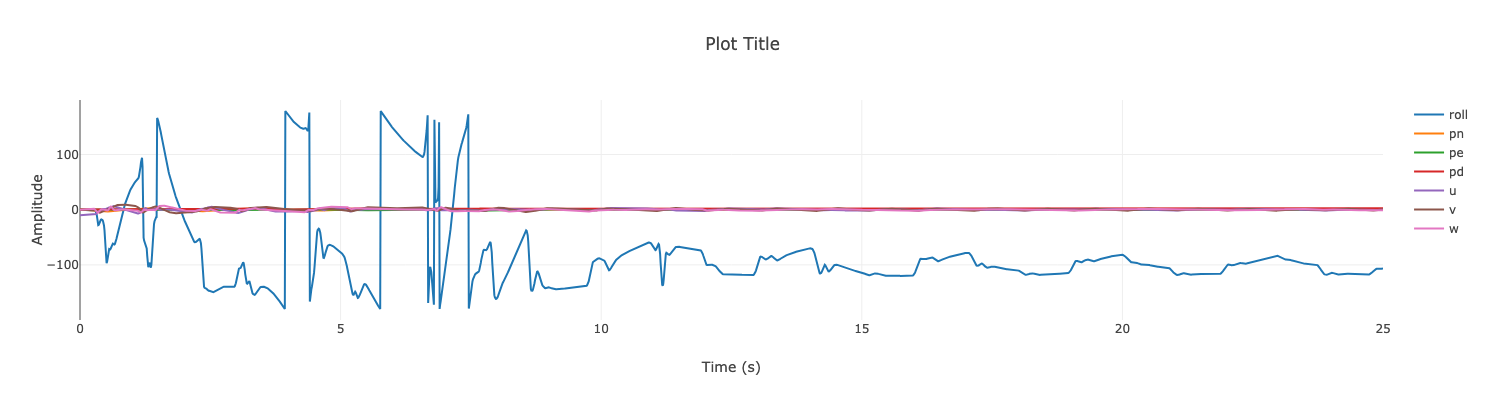

In [496]:
use plotly::*;
// Plot position vs. time
let mut plot = Plot::new();

// let trace = Scatter::new(time.clone(), q0.clone())
//     .mode(plotly::common::Mode::Lines)
//     .name("q0");
// plot.add_trace(trace);
// let trace = Scatter::new(time.clone(), q1.clone())
//     .mode(plotly::common::Mode::Lines)
//     .name("q1");
// plot.add_trace(trace);

// let trace = Scatter::new(time.clone(), Fsx.clone())
//     .mode(plotly::common::Mode::Lines)
//     .name("x");
// plot.add_trace(trace);
// let trace = Scatter::new(time.clone(), Fsy.clone())
//     .mode(plotly::common::Mode::Lines)
//     .name("y");
// plot.add_trace(trace);
// let trace = Scatter::new(time.clone(), Fsz.clone())
//     .mode(plotly::common::Mode::Lines)
//     .name("z");
// plot.add_trace(trace);

let trace = Scatter::new(time.clone(), roll.clone())
    .mode(plotly::common::Mode::Lines)
    .name("roll");
plot.add_trace(trace);

// let trace = Scatter::new(time.clone(), pitch.clone())
//     .mode(plotly::common::Mode::Lines)
//     .name("pitch");
// plot.add_trace(trace);

// let trace = Scatter::new(time.clone(), yaw.clone())
//     .mode(plotly::common::Mode::Lines)
//     .name("yaw");
// plot.add_trace(trace);

let trace = Scatter::new(time.clone(), pn.clone())
    .mode(plotly::common::Mode::Lines)
    .name("pn");
plot.add_trace(trace);
let trace = Scatter::new(time.clone(), pe.clone())
    .mode(plotly::common::Mode::Lines)
    .name("pe");
plot.add_trace(trace);
let trace = Scatter::new(time.clone(), pd.clone())
    .mode(plotly::common::Mode::Lines)
    .name("pd");
plot.add_trace(trace);

let trace = Scatter::new(time.clone(), u.clone())
    .mode(plotly::common::Mode::Lines)
    .name("u");
plot.add_trace(trace);
let trace = Scatter::new(time.clone(), v.clone())
    .mode(plotly::common::Mode::Lines)
    .name("v");
plot.add_trace(trace);
let trace = Scatter::new(time.clone(), w.clone())
    .mode(plotly::common::Mode::Lines)
    .name("w");
plot.add_trace(trace);

// Set layout properties
let layout = Layout::new()
    .title("Plot Title")
    .x_axis(plotly::layout::Axis::new().title("Time (s)"))
    .y_axis(plotly::layout::Axis::new().title("Amplitude"))
    .height(400)
    .width(800);

plot.set_layout(layout);
plot.lab_display();

In [497]:
let mut output_string = "export const data = [\n".to_string();
for i in 0..pn.len() {
    let line = format!("[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}],\n",
                       pn[i], pe[i], pd[i], q0[i], q1[i], q2[i], q3[i],
                       Fgx[i], Fgy[i], Fgz[i], Fsx[i], Fsy[i], Fsz[i], Fdx[i], Fdy[i], Fdz[i]);
    output_string.push_str(&line);
}
output_string.push_str("];");

std::fs::write("data.ts", output_string);